In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import gfile
import imageio
import pickle
import scipy.misc
import sys
from IPython.display import HTML
import imageio
%matplotlib inline

In [2]:
def transform(image, resize_height=48, resize_width=48):
    cropped_image = scipy.misc.imresize(image, [resize_height, resize_width])
    return np.array(cropped_image)/127.5 - 1.
def inverse_transform(images):
    return (images+1.)/2.

In [3]:
def toint(frame):
    return frame[:, :, ::-1]

In [4]:
videos = gfile.Glob("/home/andrewliu/research/viewpoint/pour/*cropped.mp4")
# videos = pickle.load(open('videolist.pkl', 'rb'))
idata = [[] for _ in range(50)]
nfail = 0
idim = (48, 48)
itr = 0
np.random.shuffle(videos)
for name in videos:
    try:
        vid = imageio.get_reader(name,  'ffmpeg')
        if itr % 10 == 0:
            print(itr, map(len, idata))
        nlen = len(vid)
        frames = []
        for j in range(50):
            frame = transform(vid.get_data(j))
            frames.append(frame)
        for j, f in enumerate(frames):
            idata[j].append(f)
        itr += 1
    except:
        nfail += 1
        print("Unexpected error:", sys.exc_info())
        print(name)
        if nfail > 10:
            break

0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
10 [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
20 [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
30 [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]
40 [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40]
50 [50, 50, 50, 50, 50, 50, 50,

In [5]:
vdata = np.array(idata)
vdata.shape

(50, 121, 48, 48, 3)

In [7]:
vdata = np.load('vdata_pour.npy')

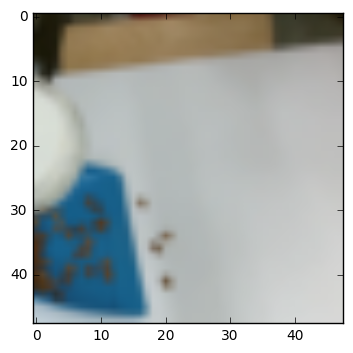

In [6]:
plt.imshow(inverse_transform(vdata[-1][4]))

In [7]:
np.save('vdata_pour', vdata)

In [10]:
# np.random.shuffle(np.swapaxes(vdata, 0, 1))

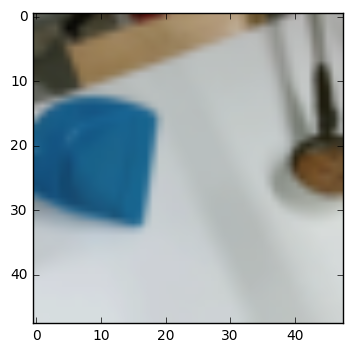

In [8]:
plt.imshow(inverse_transform(vdata[0][12]))

In [9]:
def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)

def conv2d(input_, output_dim, 
       k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02,
       name="conv2d"):
    with tf.variable_scope(name):
        w = tf.get_variable('w', [k_h, k_w, input_.get_shape()[-1], output_dim],
                  initializer=tf.truncated_normal_initializer(stddev=stddev))
#         print("c", w.get_shape())
        conv = tf.nn.conv2d(input_, w, strides=[1, d_h, d_w, 1], padding='SAME')

        biases = tf.get_variable('biases', [output_dim], initializer=tf.constant_initializer(0.0))
        conv = tf.reshape(tf.nn.bias_add(conv, biases), conv.get_shape())

    return conv
class batch_norm(object):
    def __init__(self, epsilon=1e-5, momentum = 0.9, name="batch_norm"):
        with tf.variable_scope(name):
            self.epsilon  = epsilon
            self.momentum = momentum
            self.name = name

    def __call__(self, x):
        return tf.contrib.layers.batch_norm(x,
                      decay=self.momentum, 
                      updates_collections=None,
                      epsilon=self.epsilon,
                      scale=True,
                      is_training=tftrain,
                      scope=self.name)
def linear(input_, output_size, scope=None, stddev=0.02, bias_start=0.0, with_w=False):
    shape = input_.get_shape().as_list()

    with tf.variable_scope(scope or "Linear"):
        matrix = tf.get_variable("Matrix", [shape[1], output_size], tf.float32,
                 tf.random_normal_initializer(stddev=stddev))
        bias = tf.get_variable("bias", [output_size],
              initializer=tf.constant_initializer(bias_start))
    if with_w:
        return tf.matmul(input_, matrix) + bias, matrix, bias
    else:
        return tf.matmul(input_, matrix) + bias
    

def deconv2d(input_, output_shape,
       k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02,
       name="deconv2d", with_w=False):
    with tf.variable_scope(name):
        # filter : [height, width, output_channels, in_channels]
        w = tf.get_variable('w', [k_h, k_w, output_shape[-1], input_.get_shape()[-1]],
                  initializer=tf.random_normal_initializer(stddev=stddev))
#         print("w", w.get_shape())
        try:
            deconv = tf.nn.conv2d_transpose(input_, w, output_shape=output_shape,
                    strides=[1, d_h, d_w, 1])

        # Support for verisons of TensorFlow before 0.7.0
        except AttributeError:
            deconv = tf.nn.deconv2d(input_, w, output_shape=output_shape,
                    strides=[1, d_h, d_w, 1])

        biases = tf.get_variable('biases', [output_shape[-1]], initializer=tf.constant_initializer(0.0))
        deconv = tf.reshape(tf.nn.bias_add(deconv, biases), deconv.get_shape())

        if with_w:
            return deconv, w, biases
        else:
            return deconv

In [10]:
class ContextAE:
    def __init__(self, gf_dim=64, df_dim=64,
                 gfc_dim=1024, dfc_dim=1024,
                 c_dim=3):
        self.gf_dim = gf_dim
        self.df_dim = df_dim
        self.c_dim = c_dim

        self.gfc_dim = gfc_dim
        self.dfc_dim = dfc_dim


    def build(self, image):
        imgshape = image.get_shape().as_list()
        print(imgshape)
        self.output_height, self.output_width = imgshape[-3:-1]
        self.batch_size = imgshape[1]
        featsize = 100
        srcimg = image[0]
        tgtimg = image[2]
        tgtctx = image[1]
        
        nf0 = 32
        nf1 = 16
        nf2 = 16
        nf3 = 8
        ns0 = 1
        ns1 = 2
        ns2 = 1
        ns3 = 2
#         with tf.variable_scope("conv_context") as scope:

        def encode(img):
            img_h0 = lrelu(conv2d(img, nf0, d_h=ns0, d_w=ns0, name='h0_conv'))
            img_h1 = lrelu(conv2d(img_h0, nf1, d_h=ns1, d_w=ns1, name='h1_conv'))
            img_h2 = lrelu(conv2d(img_h1, nf2, d_h=ns2, d_w=ns2, name='h2_conv'))
            img_h3 = lrelu(conv2d(img_h2, nf3, d_h=ns3, d_w=ns3, name='h3_conv'))
            print(img_h3.get_shape())
            img_h4 = lrelu(linear(tf.nn.dropout(tf.reshape(img_h3, [self.batch_size, -1]), keep_prob), featsize, 'h4_lin'))
            img_z = lrelu(linear(tf.nn.dropout(img_h4, keep_prob), featsize, 'hz_lin'))
            return img_h0, img_h1, img_h2, img_h3, img_h4, img_z
        
        with tf.variable_scope("conv") as scope:
            srcimg_h0, srcimg_h1, srcimg_h2, srcimg_h3, srcimg_h4, srcimg_z = encode(srcimg)
            scope.reuse_variables()
            tgtimg_h0, tgtimg_h1, tgtimg_h2, tgtimg_h3, tgtimg_h4, tgtimg_z = encode(tgtimg)
            tgtctx_h0, tgtctx_h1, tgtctx_h2, tgtctx_h3, tgtctx_h4, tgtctx_z = encode(tgtctx)

        with tf.variable_scope("translate") as scope:
            trans_h0 = lrelu(linear(tf.nn.dropout(tf.concat([srcimg_z, tgtctx_z], 1), keep_prob), featsize, 'trans_h0'))
            trans_z = linear(tf.nn.dropout(trans_h0, keep_prob), featsize, 'trans_z')
            self.translated_z = trans_z
        
        s_h, s_w = self.output_height, self.output_width
        s_h0, s_h1, s_h2, s_h3 = \
            int(s_h/ns0), int(s_h/ns0/ns1), int(s_h/ns0/ns1/ns2), int(s_h/ns0/ns1/ns2/ns3)
        s_w0, s_w1, s_w2, s_w3 = \
            int(s_w/ns0), int(s_w/ns0/ns1), int(s_w/ns0/ns1/ns2), int(s_w/ns0/ns1/ns2/ns3)
            
        def decode(z, skip_h3, skip_h2, skip_h1, skip_h0):
            z_ = lrelu(linear(tf.nn.dropout(z, keep_prob), nf3*s_h3*s_w3, 'd_h0_lin'))
            h0 = tf.nn.dropout(tf.reshape(z_, [-1, s_h3, s_w3, nf3]), keep_prob)
            h1 = lrelu(deconv2d(tf.concat([h0, skip_h3], 3),
                    [self.batch_size, s_h2, s_w2, nf2], name='d_h1', d_h=ns3, d_w=ns3))
            h2 = lrelu(deconv2d(tf.concat([h1, skip_h2], 3),
                    [self.batch_size, s_h1, s_w1, nf1], name='d_h2', d_h=ns2, d_w=ns2))
            h3 = lrelu(deconv2d(tf.concat([h2, skip_h1], 3),
                    [self.batch_size, s_h0, s_w0, nf0], name='d_h3', d_h=ns1, d_w=ns1))
            print(h3.get_shape())
            h4 = deconv2d(tf.concat([h3, skip_h0], 3),
                    [self.batch_size, s_h, s_w, self.c_dim], name='d_h4', d_h=ns0, d_w=ns0)
            return h4
        with tf.variable_scope("deconv") as scope:
            output_h4 = decode(trans_z, tgtctx_h3, tgtctx_h2, tgtctx_h1, tgtctx_h0)
            scope.reuse_variables()
            truthoutput_h4 = decode(tgtimg_z, tgtctx_h3, tgtctx_h2, tgtctx_h1, tgtctx_h0)

        self.simloss = tf.reduce_mean((trans_z - tgtimg_z) ** 2) * 1e3
        print(tgtimg_z.get_shape())
        self.out = output_h4
        self.out2 = truthoutput_h4
        print(self.out.get_shape())
        self.recon1 = tf.nn.l2_loss(tgtimg - self.out)
        self.recon2 = tf.nn.l2_loss(tgtimg - self.out2)
        self.loss = self.recon1 + self.recon2 + self.simloss

In [11]:
tf.reset_default_graph()
idim = (48, 48)
keep_prob = tf.placeholder(tf.float32, name='keep_prob')
tftrain = tf.placeholder(tf.bool, name='tftrain')
batch_size=100
tfinput = tf.placeholder(tf.float32, (3, batch_size) + idim + (3, ), name='x')
test = ContextAE()
test.build(tfinput)

[3, 100, 48, 48, 3]
(100, 12, 12, 8)
(100, 12, 12, 8)
(100, 12, 12, 8)
(100, 48, 48, 32)
(100, 48, 48, 32)
(100, 100)
(100, 48, 48, 3)


In [12]:
config = tf.ConfigProto(
#     device_count = {'GPU': 0}
                       )
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
learning_rate = tf.placeholder(tf.float32, shape=[])
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(test.loss)
sess.run(tf.global_variables_initializer())
allloss = []
validloss = []
itr = 0
saver = tf.train.Saver()

In [249]:
# new_saver = tf.train.import_meta_graph('viewpoint1000-DSG4239.meta')
# new_saver.restore(sess, 'viewpoint1000-DSG4239')

In [60]:
saver.restore(sess, './ctxskiprealpour23569')
# ctxskipreal44708
# ctxskipreal322739

INFO:tensorflow:Restoring parameters from ./ctxskiprealpour23569


In [259]:
optimizer2 = tf.train.AdamOptimizer(learning_rate).minimize(test.loss)
uninitialized_vars = []
for var in tf.all_variables():
    try:
        sess.run(var)
    except tf.errors.FailedPreconditionError:
        uninitialized_vars.append(var)

init_new_vars_op = tf.initialize_variables(uninitialized_vars)
sess.run(init_new_vars_op)

Instructions for updating:
Please use tf.global_variables instead.
Instructions for updating:
Use `tf.variables_initializer` instead.


In [42]:
saver.save(sess, 'ctxskiprealpour'+str(itr))

'ctxskiprealpour23569'

In [1]:
itr

NameError: name 'itr' is not defined

In [2]:
np.sum(np.max(np.max(np.max(vdata, axis=-1), axis=-1), axis=-1)==-1)

NameError: name 'np' is not defined

In [55]:
print(vdata.shape)
n = vdata.shape[1]
nlen = 50
ntrain = 105
nvalid = n - ntrain
print(ntrain, nvalid)
validdata = vdata[:, ntrain:]
traindata = vdata[:, :ntrain]
print(validdata.shape, traindata.shape)
while True:
    choicesrc = np.random.choice(ntrain, batch_size)
    choicetgt = np.random.choice(ntrain, batch_size)
    srcdata = traindata[np.arange(0, batch_size) % nlen, choicesrc]
    tgtdata = traindata[np.arange(0, batch_size) % nlen, choicetgt]
    tgtctx = traindata[0, choicetgt]
    batch = [srcdata, tgtctx, tgtdata]
    
#     print(sess.run( [test.recon1, test.recon2, test.loss, test.simloss], {tfinput: batch, learning_rate:1e-4, tftrain:False}))
    _, loss, sim, r1, r2 = sess.run( [optimizer, test.loss, test.simloss, test.recon1, test.recon2], 
                                    {tfinput: batch, learning_rate:1e-3, tftrain:False, keep_prob:0.5})
    if itr % 4 == 0:
        print(loss, sim, r1, r2)
        allloss.append(loss)
    
    if itr % 40 == 0:
        choicesrc = np.random.choice(nvalid, batch_size)
        choicetgt = np.random.choice(nvalid, batch_size)
        srcdata = validdata[np.arange(0, batch_size) % nlen, choicesrc]
        tgtdata = validdata[np.arange(0, batch_size) % nlen, choicetgt]
        tgtctx = validdata[0, choicetgt]
        batch = [srcdata, tgtctx, tgtdata]
        loss, sim, r1, r2 = sess.run([test.loss, test.simloss, test.recon1, test.recon2], 
                                     {tfinput: batch, tftrain:False, keep_prob:1.0})
        print(loss, sim, r1, r2,'E')
        validloss.append(loss)
    itr += 1
#     if itr > 526*40:
#         break

(50, 121, 48, 48, 3)
105 16
(50, 16, 48, 48, 3) (50, 105, 48, 48, 3)
11055.6 103.875 6454.12 4497.59
11369.1 73.2338 6847.65 4448.23
10933.8 59.0074 6762.03 4112.79
10562.3 81.9186 6057.84 4422.52
10696.6 80.438 6554.11 4062.1
10900.7 74.3934 6629.92 4196.38
12237.9 73.7264 7331.91 4832.22
10743.2 80.0199 6647.85 4015.3
10972.9 64.0225 6264.07 4644.77
10651.1 67.4254 6181.96 4401.67
25286.1 50.2309 15363.8 9872.1 E
10788.9 68.6873 6502.71 4217.47
10414.3 64.5337 6009.88 4339.9
12489.1 75.5284 7756.39 4657.16
11198.3 69.468 6769.91 4358.88
11835.9 69.2917 6970.43 4796.22
11797.2 76.2346 7008.5 4712.5
11659.3 75.8139 6905.2 4678.26
10952.2 67.2767 6727.55 4157.35
11128.3 70.2531 6461.54 4596.55
10978.4 81.5613 6839.42 4057.4
23412.6 49.5469 14548.6 8814.45 E
11918.3 74.9416 7255.15 4588.23
10390.6 61.8741 5861.0 4467.77
10364.3 57.2142 5940.01 4367.09
11318.8 70.7191 6804.48 4443.57
13107.1 80.0682 7934.85 5092.16


KeyboardInterrupt: 

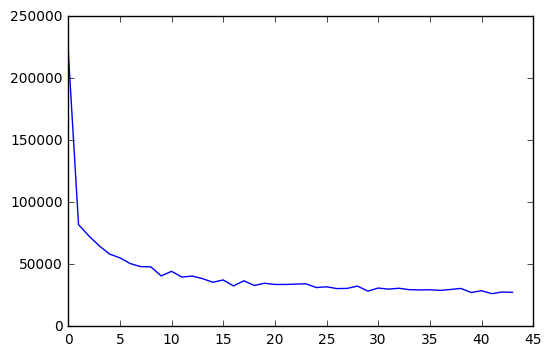

In [17]:
plt.plot(validloss)

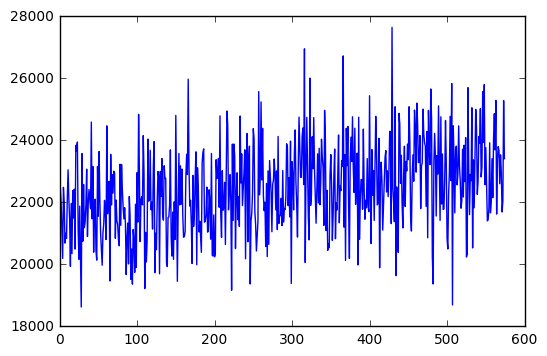

In [59]:
plt.plot(validloss[1000:])

In [48]:
np.argmin(validloss)

716

In [21]:
def savegif(name, frames):
    with imageio.get_writer(name, mode='I') as writer:
        for f in frames:
            writer.append_data((inverse_transform(f)*255).astype(np.uint8))
def disimgs(imgs):
    strs = ''
    for img in imgs:
        strs += '<img src="%s?rand=%f" width="200px"/><br/>'%(img, np.random.rand())
    return HTML(strs)

In [22]:
import skvideo.io
itrand = 0
def toint(frame):
    return scipy.misc.imresize((np.clip(inverse_transform(frame), 0, 1) * 255).astype(np.uint8), 
                          (frame.shape[0] * 10, frame.shape[1] * 10), interp='nearest')[:, :, ::-1]
def writevideo(name, data):
    rate = "20"
    writer = skvideo.io.FFmpegWriter(name, inputdict={
          '-r': rate,
        },
        outputdict={
          '-r': rate,
    })
    for i in xrange(data.shape[0]):
        writer.writeFrame(toint(data[i]))
    writer.close()

In [53]:
for kk in range(10):
    itrand += 1
    choicesrc = [np.random.randint(nvalid)] * batch_size
    choicetgt = [np.random.randint(nvalid)] * batch_size
    srcdata = validdata[np.arange(0, batch_size) % 50, choicesrc]
    tgtdata = validdata[np.arange(0, batch_size) % 50, choicetgt]
    tgtctx = validdata[0, choicetgt]
    batch = [srcdata, tgtctx, tgtdata]

    L, r1, r2, testouts= sess.run([test.loss, test.recon1, test.recon2, test.out], {tfinput: batch, tftrain: False, keep_prob:1.0})


    L, r1, r2, testouts2= sess.run([test.loss, test.recon1, test.recon2, test.out2], {tfinput: batch, tftrain: False, keep_prob:1.0})


    print(L, r1, r2)
#     filmstrip(srcdata[:50], 'fig/sweep%dsrc.jpg'%itrand)
#     filmstrip(testouts[:50], 'fig/sweep%dtrans.jpg'%itrand)
#     scipy.misc.imsave('fig/sweep%dctx.png'%itrand, tgtdata[0])

#     writevideo("videos/robot/trans/%dsrc.mp4" %itrand, srcdata[:50])
#     writevideo("videos/robot/trans/%dtrans.mp4" %itrand, testouts[:50])
#     scipy.misc.imsave('videos/robot/trans/%dctx.png'%itrand, toint(tgtdata[0]))
    # fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(9,9))
    # for i in range(25):
    #     axx = ax[i//5][i%5]
    #     axx.imshow(inverse_transform(testouts2[i]))
    #     axx.axis('off')
    # plt.tight_layout()


    # fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(9,9))
    # for i in range(25):
    #     axx = ax[i//5][i%5]
    #     axx.imshow(inverse_transform(testouts[i]))
    #     axx.axis('off')
    # plt.tight_layout()

    # fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(9,9))
    # for i in range(25):
    #     axx = ax[i//5][i%5]
    #     axx.imshow(inverse_transform(tgtdata[i]))
    #     axx.axis('off')
    # plt.tight_layout()
    # for k in range(25):
    #     plt.figure()
    #     plt.imshow(inverse_transform(tgtdata[k]))
    #     plt.figure()
    #     plt.imshow(inverse_transform(testouts[k]))

12762.4 8039.03 4708.09
12614.6 7256.25 5338.21
15384.1 10708.4 4649.84
24706.4 15886.7 8792.95
19511.0 10697.8 8792.95
23544.9 13043.9 10487.2
24015.2 13510.7 10487.2
24653.5 16166.4 8465.49
20086.9 14883.6 5170.06
12280.0 7245.95 5017.69


In [61]:
imgs = []
for i in range(nvalid):
    choicesrc = [(i+1)%nvalid] * batch_size#np.random.choice(nvalid, batch_size)
    choicetgt = [i] * batch_size
    srcdata = traindata[np.arange(0, batch_size) % nlen, choicesrc]
    tgtdata = validdata[np.arange(0, batch_size) % nlen, choicetgt]
    tgtctx = validdata[0, choicetgt]
    batch = [srcdata, tgtctx, tgtdata]

    L, r1, r2, testouts= sess.run([test.loss, test.recon1, test.recon2, test.out], 
                                  {tfinput: batch, tftrain: False, keep_prob:1.0})


    L, r1, r2, testouts2= sess.run([test.loss, test.recon1, test.recon2, test.out2], 
                                   {tfinput: batch, tftrain: False, keep_prob:1.0})


    print(L, r1, r2)
    i1 = "gif/__out%d.gif"%i
    i2 = "gif/__out2_%d.gif"%i
    i3 = "gif/__truth%d.gif"%i
    savegif(i1, testouts[:nlen])
    savegif(i2, testouts2[:nlen])
    savegif(i3, tgtdata[:nlen])
    imgs.extend([i1, i2, i3])
disimgs(imgs)

34036.0 20869.2 13137.1
8922.27 5348.7 3556.16
19619.8 11093.2 8512.33
25793.9 15065.6 10699.9
19152.9 11830.0 7298.25
15834.8 9588.33 6236.12
14551.5 8968.86 5558.57
17996.2 11382.4 6590.98
15217.9 11558.1 3637.4
13835.5 9148.25 4670.36
16126.3 11237.9 4858.24
18403.5 9883.09 8498.21
23288.4 14278.0 8990.09
11755.5 6806.22 4928.4
20924.8 10907.5 9991.2
22554.4 10213.8 12288.2


In [31]:
choicesrc = [0] * batch_size#np.random.choice(nvalid, batch_size)
choicetgt = [5] * batch_size
srcdata = validdata[np.arange(0, batch_size) % nlen, choicesrc]
tgtdata = validdata[np.arange(0, batch_size) % nlen, choicetgt]
tgtctx = validdata[0, choicetgt]
batch = [srcdata, tgtctx, tgtdata]

L, r1, r2, testouts= sess.run([test.loss, test.recon1, test.recon2, test.out], 
                              {tfinput: batch, tftrain: False, keep_prob:1.0})


L, r1, r2, testouts2= sess.run([test.loss, test.recon1, test.recon2, test.out2], 
                               {tfinput: batch, tftrain: False, keep_prob:1.0})


print(L, r1, r2)
i = 4
i1 = "gif/__out%d.gif"%i
i2 = "gif/__out2_%d.gif"%i
i3 = "gif/__truth%d.gif"%i
savegif(i1, testouts[:nlen])
savegif(i2, testouts2[:nlen])
savegif(i3, tgtdata[:nlen])
imgs = [i1, i2, i3]
disimgs(imgs)

18084.9 10315.9 7751.65


In [20]:
def savesequence(frames, formats):
    for idx, f in enumerate(frames):
        scipy.misc.imsave(formats%idx, np.clip(inverse_transform(f)[...,::-1], 0, 1))
savesequence(testouts[1:50:2], 'figs/real2/trans%d.png')
savesequence(tgtdata[1:50:2], 'figs/real2/tgt%d.png')
savesequence(srcdata[1:50:2], 'figs/real2/src%d.png')

7
14
21
28
35
42
49


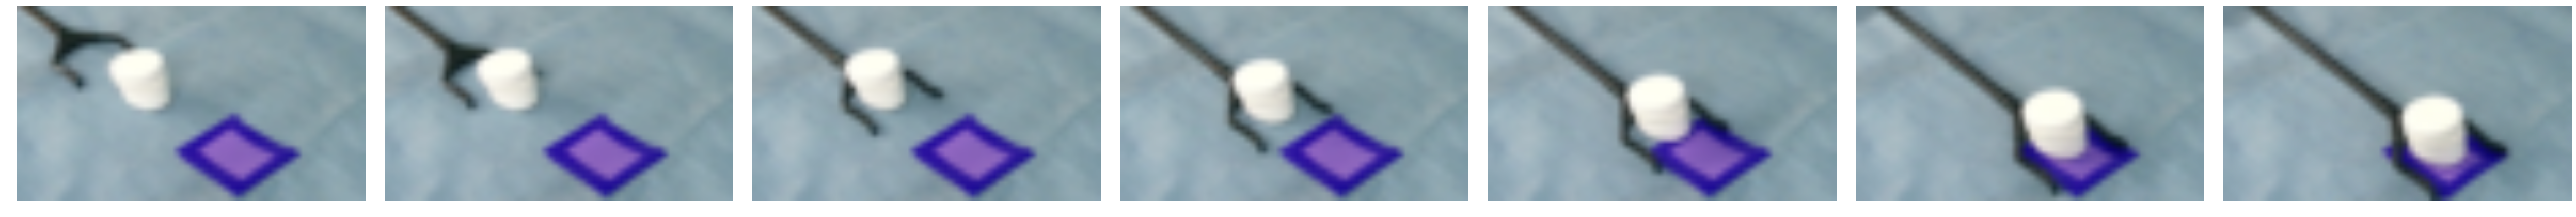

In [15]:
skip = 7
nlen = 50
fig, ax = plt.subplots(nrows=1, ncols=nlen//skip, figsize=(50,10))
for i in range(nlen//skip):
    axx = ax[i]
    axx.imshow(inverse_transform(srcdata[i*skip + nlen - nlen//skip *(skip-1)-1]))
    print(i*skip + nlen - nlen//skip *(skip-1)-1)
    axx.axis('off')
plt.tight_layout()
# plt.subplots_adjust(left=-0.1, right=0.5, top=1, bottom=0)

7
14
21
28
35
42
49


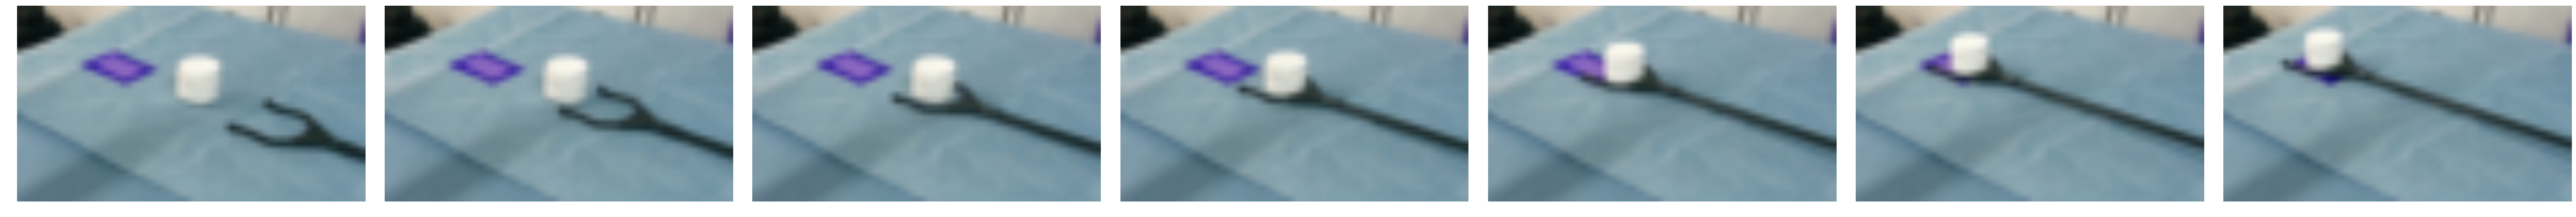

In [16]:
skip = 7
nlen = 50
fig, ax = plt.subplots(nrows=1, ncols=nlen//skip, figsize=(50,10))
for i in range(nlen//skip):
    axx = ax[i]
    axx.imshow(inverse_transform(tgtdata[i*skip + nlen - nlen//skip *(skip-1)-1]))
    print(i*skip + nlen - nlen//skip *(skip-1)-1)
    axx.axis('off')
plt.tight_layout()
# plt.subplots_adjust(left=-0.1, right=0.5, top=1, bottom=0)

7
14
21
28
35
42
49


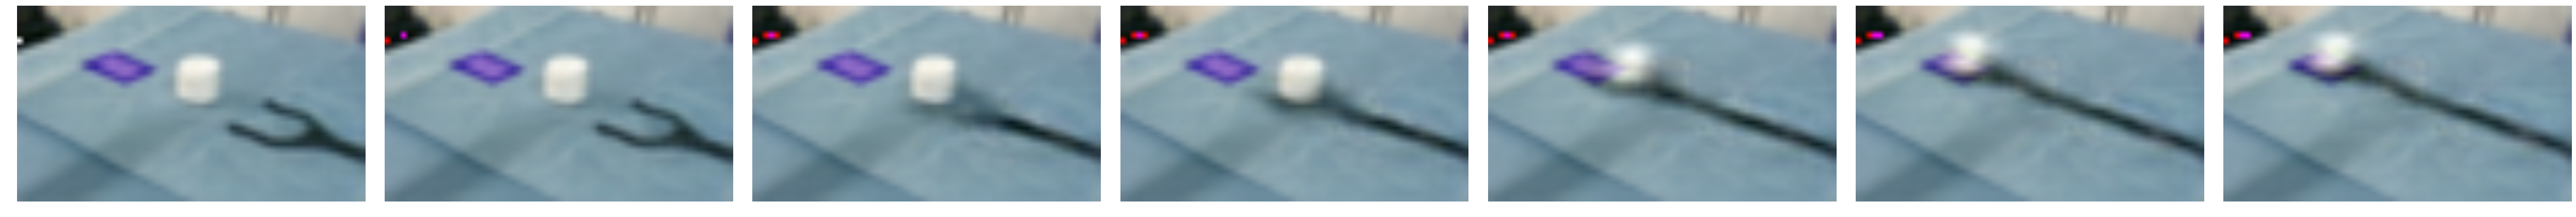

In [17]:
skip = 7
nlen = 50
fig, ax = plt.subplots(nrows=1, ncols=nlen//skip, figsize=(50,10))
for i in range(nlen//skip):
    axx = ax[i]
    axx.imshow(inverse_transform(testouts[i*skip + nlen - nlen//skip *(skip-1)-1]))
    print(i*skip + nlen - nlen//skip *(skip-1)-1)
    axx.axis('off')
plt.tight_layout()
# plt.subplots_adjust(left=-0.1, right=0.5, top=1, bottom=0)

In [18]:
goodvalids = range(20)
goodvalids.remove(16)
goodvalids.remove(15)
goodvalids.remove(14)

In [202]:
imgs = []
for i in goodvalids:
    choicesrc = [0] * batch_size#np.random.choice(nvalid, batch_size)
    choicetgt = [i] * batch_size
    srcdata = validdata[np.arange(0, batch_size) % nlen, choicesrc]
    tgtdata = validdata[np.arange(0, batch_size) % nlen, choicetgt]
    tgtctx = validdata[0, choicetgt]
    batch = [srcdata, tgtctx, tgtdata]

    L, r1, r2, testouts= sess.run([test.loss, test.recon1, test.recon2, test.out], 
                                  {tfinput: batch, tftrain: False, keep_prob:1.0})


    L, r1, r2, testouts2= sess.run([test.loss, test.recon1, test.recon2, test.out2], 
                                   {tfinput: batch, tftrain: False, keep_prob:1.0})


    print(L, r1, r2)
    i1 = "gif/_out%d.gif"%i
    i2 = "gif/_out2_%d.gif"%i
    i3 = "gif/_truth%d.gif"%i
    savegif(i1, testouts[:nlen])
    savegif(i2, testouts2[:nlen])
    savegif(i3, tgtdata[:nlen])
    imgs.extend([i1, i2, i3])
disimgs(imgs)

4423.92 2263.68 2153.16
7079.25 3532.84 3536.12
6265.11 2671.32 3584.11
8265.72 4341.84 3911.96
7004.93 3551.66 3448.47
5300.8 3049.61 2245.2
3020.76 1464.48 1551.07
5560.4 2837.67 2718.28
10695.2 5504.73 5184.32
6223.04 3304.53 2913.99
6742.65 3251.05 3481.39
8551.54 4385.5 4160.1
6791.15 3376.94 3407.29
7031.04 3492.46 3534.25
4228.89 2176.53 2047.24
6742.81 3573.01 3163.19
3489.96 1726.81 1757.61


4828

In [80]:
feats = []
for i in range(nvalid):
    if i % 100 == 0:
        print(i)
    choicesrc = [i] * batch_size
    choicetgt = [1] * batch_size
    srcdata = validdata[np.arange(0, batch_size) % nlen, choicesrc]
    tgtdata = validdata[np.arange(0, batch_size) % nlen, choicetgt]
    tgtctx = validdata[0, choicetgt]
    batch = [srcdata, tgtctx, tgtdata]
    feats.append(sess.run( test.translated_z, 
        {tftrain: False, tfinput: batch, keep_prob:1.0})[:nlen])

0


In [81]:
tffeats = np.array(feats)
tffeats.shape

(15, 50, 10)

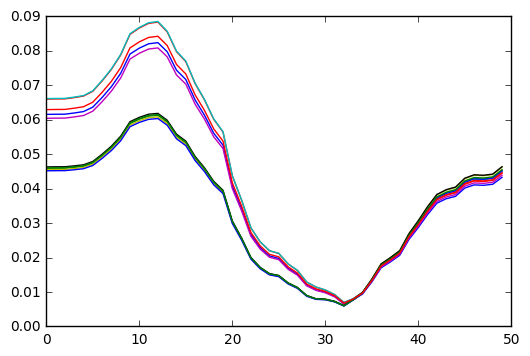

In [82]:
_=plt.plot(np.std(tffeats, axis=0))

In [83]:
means = np.mean(tffeats, axis=0)
means.shape

(50, 10)

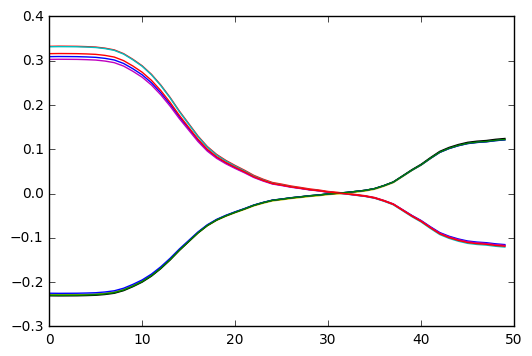

In [84]:
_=plt.plot(means)

In [85]:
np.save('ctxvalidreal', validdata[:, goodvalids])

NameError: name 'goodvalids' is not defined

In [84]:
np.save('ctxfeatsdistract250', means)

In [ ]:
print(vdata.shape)
n = vdata.shape[1]
nlen = 50
ntrain = 180
nvalid = n - ntrain
print(ntrain, nvalid)
validdata = vdata[:, ntrain:]
traindata = vdata[:, :ntrain]
print(validdata.shape, traindata.shape)
while True:
    choicesrc = np.random.choice(ntrain, batch_size)
    choicetgt = np.random.choice(ntrain, batch_size)
    srcdata = traindata[np.arange(0, batch_size) % nlen, choicesrc]
    tgtdata = traindata[np.arange(0, batch_size) % nlen, choicetgt]
    tgtctx = traindata[0, choicetgt]
    batch = [srcdata, tgtctx, tgtdata]
    
#     print(sess.run( [test.recon1, test.recon2, test.loss, test.simloss], {tfinput: batch, learning_rate:1e-4, tftrain:False}))
    _, loss, sim, r1, r2 = sess.run( [optimizer, test.loss, test.simloss, test.recon1, test.recon2], 
                                    {tfinput: batch, learning_rate:1e-4, tftrain:False, keep_prob:0.5})
    if itr % 4 == 0:
        print(loss, sim, r1, r2)
        allloss.append(loss)
    
    if itr % 40 == 0:
        choicesrc = np.random.choice(nvalid, batch_size)
        choicetgt = np.random.choice(nvalid, batch_size)
        srcdata = validdata[np.arange(0, batch_size) % nlen, choicesrc]
        tgtdata = validdata[np.arange(0, batch_size) % nlen, choicetgt]
        tgtctx = validdata[0, choicetgt]
        batch = [srcdata, tgtctx, tgtdata]
        loss, sim, r1, r2 = sess.run([test.loss, test.simloss, test.recon1, test.recon2], 
                                     {tfinput: batch, tftrain:False, keep_prob:1.0})
        print(loss, sim, r1, r2,'E')
        validloss.append(loss)
        choicesrc = np.random.choice(ntrain, batch_size)
#     choicetgt = np.random.choice(ntrain, batch_size)
#     srcdata = [frames[0]] * batch_size
#     halfsize = batch_size//2
#     tgtdata = traindata[0, choicetgt]
#     tgtctx = tgtdata
#     batch = [np.concatenate([srcdata[:halfsize], tgtdata[halfsize:]], axis=0), 
#              np.concatenate([srcdata[halfsize:], tgtdata[:halfsize]], axis=0), 
#              np.concatenate([srcdata[halfsize:], tgtdata[:halfsize]], axis=0)]
    
    choicetgt = np.random.choice(ntrain, batch_size)
    srcdata = frames[np.arange(0, batch_size) % nlen]
    srcctx = [frames[0]] * batch_size
    halfsize = batch_size//2
    tgtdata = traindata[np.arange(0, batch_size) % nlen, choicetgt]
    tgtctx = traindata[0, choicetgt]
    batch = [np.concatenate([srcdata[:halfsize], tgtdata[halfsize:]], axis=0), 
             np.concatenate([srcctx[halfsize:], tgtctx[:halfsize]], axis=0), 
             np.concatenate([srcdata[halfsize:], tgtdata[:halfsize]], axis=0)]
    
    
#     print(sess.run( [test.recon1, test.recon2, test.loss, test.simloss], {tfinput: batch, learning_rate:1e-4, tftrain:False}))
    _, loss, sim, r1, r2 = sess.run( [optimizer2, test.loss, test.simloss, test.recon1, test.recon2], 
                                    {tfinput: batch, learning_rate:1e-4, tftrain:False, keep_prob:0.5})
    if itr % 4 == 0:
        print("F", loss, sim, r1, r2)
#         allloss.append(loss)
    
#     if itr % 40 == 0:
#         choicesrc = np.random.choice(nvalid, batch_size)
#         choicetgt = np.random.choice(nvalid, batch_size)
#         srcdata = validdata[np.arange(0, batch_size) % nlen, choicesrc]
#         tgtdata = validdata[np.arange(0, batch_size) % nlen, choicetgt]
#         tgtctx = validdata[0, choicetgt]
#         batch = [srcdata, tgtctx, tgtdata]
#         loss, sim, r1, r2 = sess.run([test.loss, test.simloss, test.recon1, test.recon2], 
#                                      {tfinput: batch, tftrain:False, keep_prob:1.0})
#         print(loss, sim, r1, r2,'E')
#         validloss.append(loss)
    itr += 1

In [283]:
name= '/home/andrewliu/research/viewpoint/rllab/data/s3/green-vp-distract-skip10/green_vp_distract_skip10_2017_04_24_22_30_32_0005/gym_log/openaigym.video.0.3179.video002000.mp4'
# name = '/home/andrewliu/research/viewpoint/rllab/data/local/state-mult-real/state_mult_real_2017_04_25_01_19_29_0001/gym_log/openaigym.video.0.11868.video083000.mp4'
vid = imageio.get_reader(name,  'ffmpeg')
nlen = len(vid)
frames = []
for j in range(50):
    frame = transform(vid.get_data(j * nlen // 50), 64, 64)
    frames.append(frame)
frames = np.array(frames)
savegif(giffolder+'test.gif', frames)
disimgs([giffolder+'test.gif'])

In [21]:
# name= '/home/andrewliu/research/viewpoint/realdata/test/MVI_1015.MOV'
# name = '/home/andrewliu/research/viewpoint/rllab/data/s3/real-skip2/real_skip2_2017_04_25_11_39_02_0005/gym_log/openaigym.video.0.3194.video006000.mp4'
# name = '/home/andrewliu/research/viewpoint/rllab/data/s3/real-skip3/real_skip3_2017_04_26_19_34_20_0005/gym_log/openaigym.video.0.3179.video006000.mp4'
name= '/home/andrewliu/research/viewpoint/rllab-real/data/s3/realnew-comp/realnew_comp_2017_05_08_19_23_12_0001/gym_log/openaigym.video.0.2576.video012000.mp4'
vid = imageio.get_reader(name,  'ffmpeg')
nlen = len(vid)
frames = []
for j in range(50):
    frame = transform(vid.get_data(j * nlen // 50))
    frames.append(frame)
frames = np.array(frames)

In [22]:
giffolder = 'gif/'

In [23]:
savegif(giffolder+'test.gif', frames)
disimgs([giffolder+'test.gif'])

In [25]:
nlen = 50

In [26]:
choicesrc = [0] * batch_size#np.random.choice(nvalid, batch_size)
srcdata = validdata[np.arange(0, batch_size) % nlen, choicesrc]
tgtdata = frames[np.arange(0, batch_size) % nlen]
tgtctx = [frames[0]] * batch_size
batch = [srcdata, tgtctx, tgtdata]

L, r1, r2, testouts= sess.run([test.loss, test.recon1, test.recon2, test.out], 
                              {tfinput: batch, tftrain: False, keep_prob:1.0})

L, r1, r2, testouts2= sess.run([test.loss, test.recon1, test.recon2, test.out2], 
                               {tfinput: batch, tftrain: False, keep_prob:1.0})

i = 100

print(L, r1, r2)
i1 = giffolder+"_out%d.gif"%i
i2 = giffolder+"_out2_%d.gif"%i
i3 = giffolder+"_truth%d.gif"%i
savegif(i1, testouts[:nlen])
savegif(i2, testouts2[:nlen])
savegif(i3, tgtdata[:nlen])
disimgs([i1, i2, i3])

11024.1 5082.58 5933.08


7
14
21
28
35
42
49


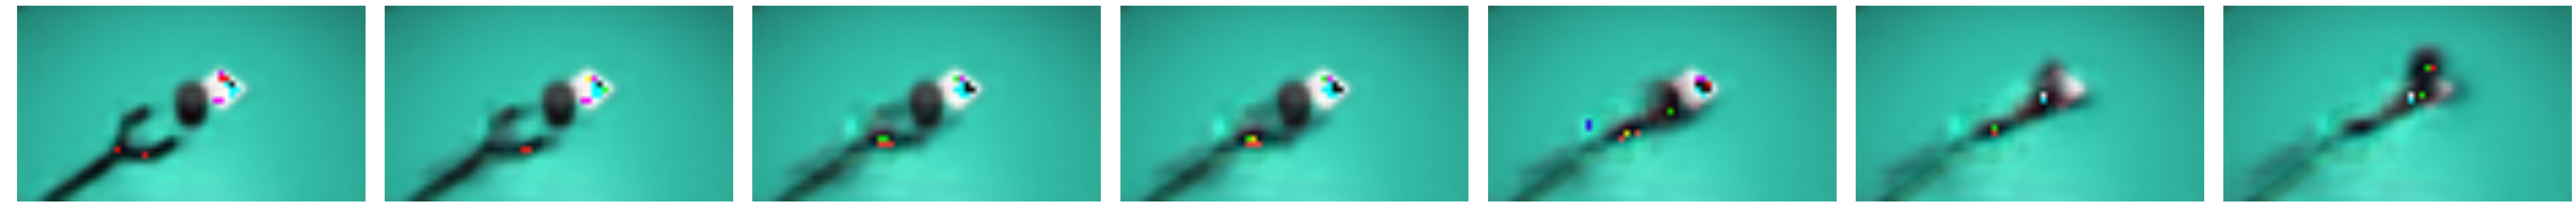

In [27]:
skip = 7
nlen = 50
fig, ax = plt.subplots(nrows=1, ncols=nlen//skip, figsize=(50,10))
for i in range(nlen//skip):
    axx = ax[i]
    axx.imshow(inverse_transform(testouts[i*skip + nlen - nlen//skip *(skip-1)-1]))
    print(i*skip + nlen - nlen//skip *(skip-1)-1)
    axx.axis('off')
plt.tight_layout()
# plt.subplots_adjust(left=-0.1, right=0.5, top=1, bottom=0)

7
14
21
28
35
42
49


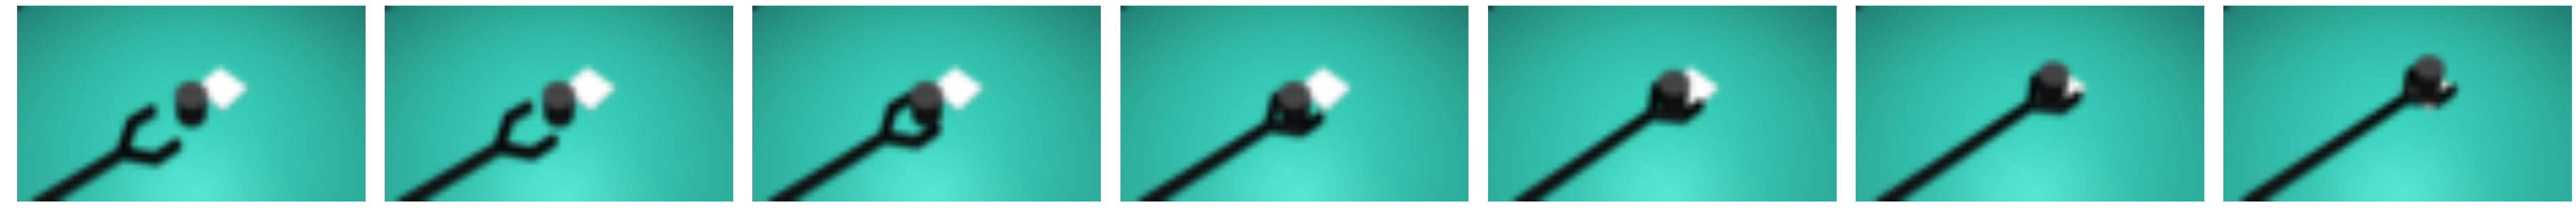

In [28]:
skip = 7
nlen = 50
fig, ax = plt.subplots(nrows=1, ncols=nlen//skip, figsize=(50,10))
for i in range(nlen//skip):
    axx = ax[i]
    axx.imshow(inverse_transform(tgtdata[i*skip + nlen - nlen//skip *(skip-1)-1]))
    print(i*skip + nlen - nlen//skip *(skip-1)-1)
    axx.axis('off')
plt.tight_layout()
# plt.subplots_adjust(left=-0.1, right=0.5, top=1, bottom=0)

In [279]:
imgs = []
for itr in range(10):
    choicesrc = [itr] * batch_size#np.random.choice(nvalid, batch_size)
    tgtdata = validdata[np.arange(0, batch_size) % nlen, choicesrc]
    srcdata = frames[np.arange(0, batch_size) % nlen]
    tgtctx = [tgtdata[0]] * batch_size
    batch = [srcdata, tgtctx, tgtdata]

    L, r1, r2, testouts= sess.run([test.loss, test.recon1, test.recon2, test.out], 
                                  {tfinput: batch, tftrain: False, keep_prob:1.0})
    print(L, r1, r2)
    i1 = giffolder+"_robotout%d.gif"%itr
    savegif(i1, testouts[:nlen])
    imgs.append(i1)
disimgs(imgs)

6376.85 3096.25 3257.56
8059.44 4170.74 3865.31
8539.47 4011.08 4491.43
9403.58 5107.59 4271.94
10223.5 5475.66 4720.05
4800.41 2615.82 2157.89
3977.12 2187.22 1766.73
6306.75 3389.79 2891.88
11059.3 5734.76 5300.74
8143.13 4278.17 3837.42


In [287]:
imgs = []
for idx in range(2040, 2055):
    try:
        name= '/home/andrewliu/research/viewpoint/realdata/test/IMG_%d.JPG' %idx
        vid = imageio.get_reader(name,  'jpg')
        ctx = transform(vid.get_data(0))
    except:
        continue

    choicesrc = [5] * batch_size#np.random.choice(nvalid, batch_size)
    srcdata = validdata[np.arange(0, batch_size) % nlen, choicesrc]
    tgtctx = [ctx] * batch_size
    tgtdata = tgtctx
    batch = [srcdata, tgtctx, tgtdata]

    L, r1, r2, testouts= sess.run([test.loss, test.recon1, test.recon2, test.out], 
                                  {tfinput: batch, tftrain: False, keep_prob:1.0})

    print(L, r1, r2)
    i1 = giffolder+"_out%d.gif"%idx
    savegif(i1, testouts[:nlen])
    imgs.append(i1)
disimgs(imgs)

18641.2 6334.82 12296.2
24578.7 9678.96 14889.7
23588.3 6605.19 16963.6
11535.3 3858.75 7661.58
12407.2 3044.58 9345.88
19872.1 10799.2 9066.41
18087.7 2385.31 15653.6
12128.0 6961.08 5156.96
18126.3 1650.43 16381.7
22795.6 2504.9 20218.1
23737.7 6419.18 17293.9
